**Load Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap


**Load Dataset**

In [ ]:
# Load dataset
df = pd.read_csv("/content/events.csv")

# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Display first few rows
df.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,view,1996170,2.144416e+18,electronics.telephone,NaN,31.90,1.515916e+18,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,view,139905,2.144416e+18,computers.components.cooler,zalman,17.16,1.515916e+18,tdicluNnRY
2,2020-09-24 11:57:27+00:00,view,215454,2.144416e+18,NaN,NaN,9.81,1.515916e+18,4TMArHtXQy
3,2020-09-24 11:57:33+00:00,view,635807,2.144416e+18,computers.peripherals.printer,pantum,113.81,1.515916e+18,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,view,3658723,2.144416e+18,NaN,cameronsino,15.87,1.515916e+18,aa4mmk0kwQ


**Data Cleaning/Preprocessing**

In [ ]:
# Check missing values
df.isnull().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,1
category_code,18279
brand,16076
price,1
user_id,1
user_session,15


In [ ]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Display missing value statistics
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_df)

               Missing Values  Percentage
event_time                  0    0.000000
event_type                  0    0.000000
product_id                  0    0.000000
category_id                 1    0.001613
category_code           18279   29.492723
brand                   16076   25.938236
price                       1    0.001613
user_id                     1    0.001613
user_session               15    0.024202


In [ ]:
# Drop rows where user_id is missing (essential for tracking users)
df.dropna(subset=['user_id'], inplace=True)

# Fill missing category_code with "Unknown"
df['category_code'].fillna("Unknown", inplace=True)

# Fill missing brand with "Unknown"
df['brand'].fillna("Unknown", inplace=True)

# Fill missing price with median price of its category_id
df['price'] = df.groupby('category_id')['price'].transform(lambda x: x.fillna(x.median()))

# Drop rows where category_id is missing (only 1 row)
df.dropna(subset=['category_id'], inplace=True)

# Fill missing user_session using forward-fill (ffill)
df['user_session'].fillna(method='ffill', inplace=True)

# Verify all missing values are handled
print(df.isnull().sum())

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64


<ipython-input-6-3549f9e51048>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category_code'].fillna("Unknown", inplace=True)
<ipython-input-6-3549f9e51048>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

**EDA**

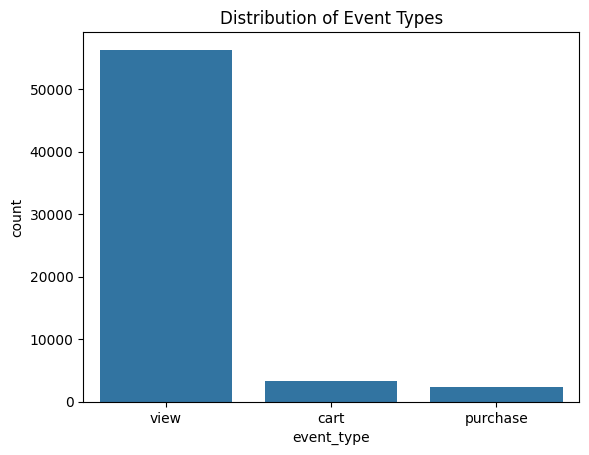

In [ ]:
sns.countplot(data=df, x='event_type')
plt.title("Distribution of Event Types")
plt.show()

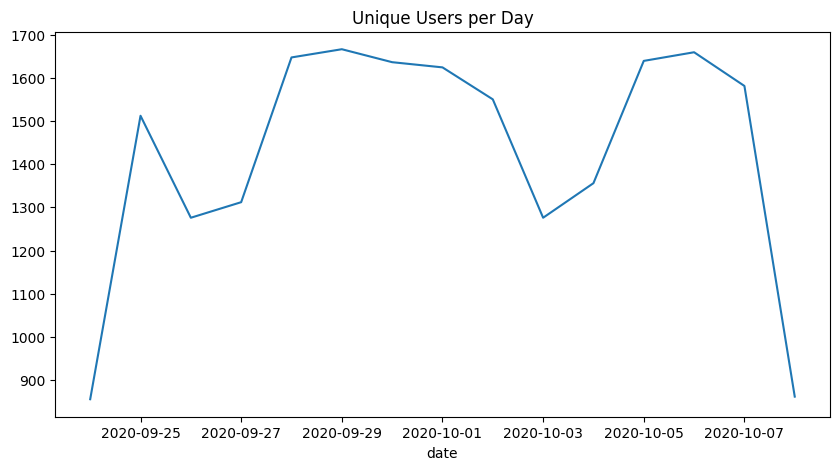

In [ ]:
df['date'] = df['event_time'].dt.date
df.groupby('date')['user_id'].nunique().plot(figsize=(10,5), title="Unique Users per Day")
plt.show()


In [ ]:
# Define churn threshold (e.g., 30 days inactivity)
latest_date = df['event_time'].max()
churn_threshold = latest_date - timedelta(days=30)

# Get last activity date for each user
user_last_activity = df.groupby('user_id')['event_time'].max()

# Define churn: If last activity was before threshold → churned (1), else active (0)
df['churn'] = df['user_id'].map(lambda x: 1 if user_last_activity[x] < churn_threshold else 0)

# Display sample users with churn status
df[['user_id', 'churn']].drop_duplicates().head()

,user_id,churn
0,1.515916e+18,0
1,1.515916e+18,0
2,1.515916e+18,0
3,1.515916e+18,0
4,1.515916e+18,0


In [ ]:
# Aggregate user-level features
user_features = df.groupby('user_id').agg({
    'event_time': lambda x: (latest_date - x.max()).days,  # Recency
    'user_session': 'nunique',  # Number of sessions
    'event_type': lambda x: (x == 'purchase').sum(),  # Total purchases
    'price': 'sum'  # Total spending
}).rename(columns={'event_time': 'recency', 'user_session': 'session_count', 'price': 'total_spent'})

# Add churn label
user_features['churn'] = user_features.index.map(lambda x: 1 if x in user_last_activity[user_last_activity < churn_threshold].index else 0)

user_features.head()


,recency,session_count,event_type,total_spent,churn
user_id,,,,,
1.515916e+18,2,1,0,28.98,0
1.515916e+18,6,1,0,274.40,0
1.515916e+18,7,1,0,722.94,0
1.515916e+18,13,1,0,105.05,0
1.515916e+18,3,1,0,32.71,0


**Model Training**

In [ ]:
# Prepare data
X = user_features.drop(columns=['churn'])
y = user_features['churn']

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape}, Testing size: {X_test.shape}")


Training size: (14536, 4), Testing size: (3635, 4)


In [ ]:
# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

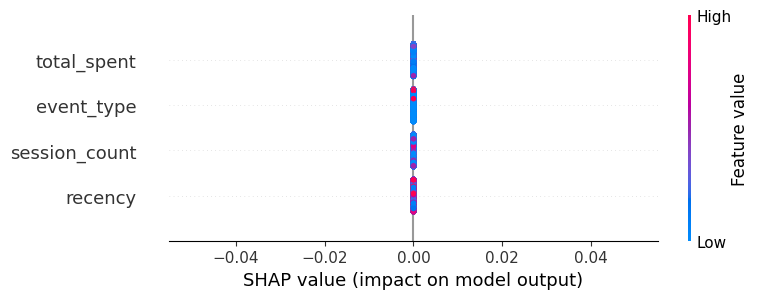

In [ ]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


**Model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score

# Predictions
y_pred = model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print results
print("📌 Model Performance Metrics:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"✅ Model Accuracy: {accuracy:.4f}")  # Prints accuracy up to 4 decimal places


📌 Model Performance Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3635

    accuracy                           1.00      3635
   macro avg       1.00      1.00      1.00      3635
weighted avg       1.00      1.00      1.00      3635

Confusion Matrix:
 [[3635]]
✅ Model Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
